## Preprocesado

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/reviews_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77406 entries, 0 to 77405
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        77406 non-null  object 
 1   review/score              77406 non-null  float64
 2   review/text               77406 non-null  int64  
 3   Title                     77406 non-null  object 
 4   authors                   77406 non-null  object 
 5   publisher                 77406 non-null  object 
 6   publishedDate             77406 non-null  int64  
 7   categories                77406 non-null  object 
 8   Price                     77406 non-null  float64
 9   conteo                    77406 non-null  int64  
 10  review_helpfulness_up     77406 non-null  int64  
 11  review_helpfulness_total  77406 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 7.1+ MB


In [3]:
df.head(3)

,Id,review/score,review/text,Title,authors,publisher,publishedDate,categories,Price,conteo,review_helpfulness_up,review_helpfulness_total
0,0312267932,4.0,620,When All Hell Breaks Loose,"['Cody Lundin', 'Russell Miller']",Gibbs Smith Publishers,2007,Health & Fitness,13.25,126,0,0
1,0312267932,5.0,146,When All Hell Breaks Loose,"['Cody Lundin', 'Russell Miller']",Gibbs Smith Publishers,2007,Health & Fitness,13.25,126,0,0
2,0312267932,4.0,429,When All Hell Breaks Loose,"['Cody Lundin', 'Russell Miller']",Gibbs Smith Publishers,2007,Health & Fitness,13.25,126,0,0


### Preprocesado para Precio

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

# preprocesado para Precio
pipeline_price = Pipeline([
    (
        'onehot-log',
        ColumnTransformer(
            transformers=[
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                        ),
                        ['publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                ),
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text','review/score', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['authors', 'Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )
])

df_cod_price = pipeline_price.fit_transform(df)

D:\Repo ciencias de datos\venv\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [5]:
df_cod_price.head(5)

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,"publisher_""O'Reilly Media, Inc.""",publisher_Ags Pub,publisher_Amber House Books,publisher_Amereon Limited,...,categories_Religion,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction,Price
0,0.415234,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
1,-1.113057,0.657171,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
2,0.025396,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
3,-0.078165,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
4,-1.500682,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25


### Preprocesado para Rating

In [6]:

from sklearn.preprocessing import FunctionTransformer
import ast

def transform_authors(authors_column):
    authors_column['authors'] = authors_column['authors'].apply(ast.literal_eval)
    authors_column['authors'] = authors_column['authors'].apply(lambda x: ', '.join(x))
    dummies = pd.get_dummies(authors_column['authors'].apply(lambda x: x.split(', ')).apply(pd.Series))
    return dummies
    # return authors_column

authors_transformer = FunctionTransformer(transform_authors, validate=False)

pipeline_rating = Pipeline([
    (
        'one-hot-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'authors',
                    authors_transformer,  # Usa el transformer personalizado para 'authors'
                    ['authors']
                ),
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                    ),
                    ['publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text', 'Price', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'rating-to-int',
        ColumnTransformer(
            transformers=[
                (
                    'rating-to-int',
                     FunctionTransformer(lambda x: x.astype(int), validate=False),
                    ['review/score']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )

])

df_cod_rating = pipeline_rating.fit_transform(df)

D:\Repo ciencias de datos\venv\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [7]:
df_cod_rating.head(5)

,review/score,review/text,Price,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,0_Agatha Christie,0_Alexander Elder,0_Alexander McCall Smith,...,categories_Reference,categories_Religion,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction
0,4,0.415234,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,5,-1.113057,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,4,0.025396,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,4,-0.078165,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,4,-1.500682,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_cod_rating.dtypes

review/score                             int32
review/text                            float64
Price                                  float64
conteo                                 float64
review_helpfulness_up                  float64
                                        ...   
categories_Sports & Recreation           uint8
categories_Technology & Engineering      uint8
categories_True Crime                    uint8
categories_Young Adult Fiction           uint8
categories_Young Adult Nonfiction        uint8
Length: 605, dtype: object

In [9]:
clases_rating = df_cod_rating['review/score'].unique()
clases_rating

array([4, 5, 3, 2, 1])

## Separacion de los datos de entrenamiento

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import time

### Separacion para Hipotesis Precio

In [11]:
df_price_train, df_price_val = train_test_split(df_cod_price, test_size=0.25, random_state=42, stratify=df_cod_price['Price'])

In [12]:
X_price_train = df_price_train.drop(columns='Price')
Y_price_train = df_price_train['Price']

X_price_val = df_price_val.drop(columns='Price')
Y_price_val = df_price_val['Price']

### Separacion para Hipotesis Rating

In [13]:
df_rating_train, df_rating_val = train_test_split(df_cod_rating, test_size=0.25, random_state=42, stratify=df_cod_rating['review/score'])

In [14]:
X_rating_train = df_rating_train.drop(columns='review/score')
Y_rating_train = df_rating_train['review/score']

X_rating_val = df_rating_val.drop(columns='review/score')
Y_rating_val = df_rating_val['review/score']

In [15]:
clases_rating = df_rating_train['review/score'].unique()
clases_rating

array([4, 5, 3, 1, 2])

### Entrenamiento para Hipotesis Rating

### Clasificador Random Forest

In [16]:
rf_rating = RandomForestClassifier(n_estimators = 120, max_depth = 15, class_weight = 'balanced')
start = time.time()
rf_rating.fit(X_rating_train, Y_rating_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end-start} segundos")

Tiempo de entrenamiento: 15.520600080490112 segundos


In [17]:
predicciones_train_rating = rf_rating.predict(X_rating_train)

In [18]:
accuracy_train_rating = accuracy_score(Y_rating_train, predicciones_train_rating)
print(f'Exactitud en los datos de entrenamiento: {accuracy_train_rating:.2f}')

Exactitud en los datos de entrenamiento: 0.60


### Clasificador MLP (Multilayer Perceptron)

In [19]:
from sklearn.neural_network import MLPClassifier

start = time.time()
mlp_rating = MLPClassifier(hidden_layer_sizes=(10,20,10), max_iter=300, activation='logistic', alpha=0.001,  random_state=17)
mlp_rating.fit(X_rating_train, Y_rating_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end-start} segundos")

Tiempo de entrenamiento: 353.1103985309601 segundos


D:\Repo ciencias de datos\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
predicciones_train_rating_MLP = mlp_rating.predict(X_rating_train)

In [21]:
accuracy_train_rating_MLP = accuracy_score(Y_rating_train, predicciones_train_rating_MLP)
print(f'Exactitud en los datos de entrenamiento: {accuracy_train_rating_MLP:.2f}')

Exactitud en los datos de entrenamiento: 0.66


### Entrenamiento para Hipotesis Precio

### Regresor MLP

In [22]:
from sklearn.neural_network import MLPRegressor

start = time.time()
mlp_precio = MLPRegressor(hidden_layer_sizes=(20,20,20), max_iter=400, activation='logistic', alpha=0.001,  random_state=17)
mlp_precio.fit(X_price_train, Y_price_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end-start}")

Tiempo de entrenamiento: 180.48849272727966


In [23]:
predicciones_train_price = mlp_precio.predict(X_price_train)
mse_price = mean_squared_error(Y_price_train, predicciones_train_price)
print(f'Error cuadrático medio: {mse_price:.2f}')

Error cuadrático medio: 7.49


In [24]:
mae_price_train = mean_absolute_error(Y_price_train, predicciones_train_price)
r2_price_train = r2_score(Y_price_train, predicciones_train_price)
rmse_price_train = np.sqrt(mse_price)
medae_prive_train = median_absolute_error(Y_price_train, predicciones_train_price)
print(f'Error absoluto medio: {mae_price_train:.2f}')
print(f'R-squared (variabilidad capturada): {r2_price_train:.2f}')
print(f'Raiz cuadrada del MSE: {rmse_price_train:.2f}')
print(f"Error Absoluto mediano: {medae_prive_train}") #Menos susceptible a valores extremos que el MAE

Error absoluto medio: 0.78
R-squared (variabilidad capturada): 0.97
Raiz cuadrada del MSE: 2.74
Error Absoluto mediano: 0.18536742357472846


### Regresor Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf_price = RandomForestRegressor(n_estimators = 150, max_depth = 15)
start = time.time()
rf_price.fit(X_price_train, Y_price_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end-start} segundos")


Tiempo de entrenamiento: 89.37285614013672 segundos


In [26]:
predicciones_train_price_rf = rf_price.predict(X_price_train)
mse_price_rf = mean_squared_error(Y_price_train, predicciones_train_price_rf)
print(f'Error cuadrático medio: {mse_price_rf:.2f}')

Error cuadrático medio: 54.93


In [27]:
mae_price_train_rf = mean_absolute_error(Y_price_train, predicciones_train_price_rf)
r2_price_train_rf = r2_score(Y_price_train, predicciones_train_price_rf)
rmse_price_train_rf = np.sqrt(mse_price_rf)
medae_prive_train_rf = median_absolute_error(Y_price_train, predicciones_train_price_rf)
print(f'Error absoluto medio: {mae_price_train_rf:.2f}')
print(f'R-squared (variabilidad capturada): {r2_price_train_rf:.2f}')
print(f'Raiz cuadrada del MSE: {rmse_price_train_rf:.2f}')
print(f"Error Absoluto mediano: {medae_prive_train_rf}") #Menos susceptible a valores extremos que el MAE

Error absoluto medio: 5.06
R-squared (variabilidad capturada): 0.79
Raiz cuadrada del MSE: 7.41
Error Absoluto mediano: 4.28091185718805


## Validación de los modelos entrenados

### Validación del modelo para la hipótesis Rating

### Clasificador Random Forest

In [28]:
predicciones_val_rating = rf_rating.predict(X_rating_val)
accuracy_val_rating = accuracy_score(Y_rating_val, predicciones_val_rating)
print(f'Exactitud en los datos de validación: {accuracy_val_rating:.2f}')

Exactitud en los datos de validación: 0.49


In [29]:
confusion_rating = confusion_matrix(Y_rating_val, predicciones_val_rating)
print("Matriz de Confusión:")
print(confusion_rating)

Matriz de Confusión:
[[1014  222   70   68  147]
 [ 369  218  104  162  172]
 [ 291  207  194  470  454]
 [ 352  281  229 1314 1382]
 [1332  592  456 2536 6716]]


In [30]:
clases_rating_val = df_rating_val['review/score'].unique()

In [31]:
type(clases_rating_val)

numpy.ndarray

In [32]:
clases_rating_val.shape

(5,)

In [33]:
def plot_confusion_matrix(confusion, width, height, etiquetas_clases):
    plt.figure(figsize=(height, width))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

    if etiquetas_clases is not None and len(etiquetas_clases) > 0:
        plt.xticks(range(len(etiquetas_clases)), etiquetas_clases, rotation=90)
        plt.yticks(range(len(etiquetas_clases)), etiquetas_clases, rotation=0)


    # Agrega etiquetas y títulos
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.title('Matriz de Confusión')

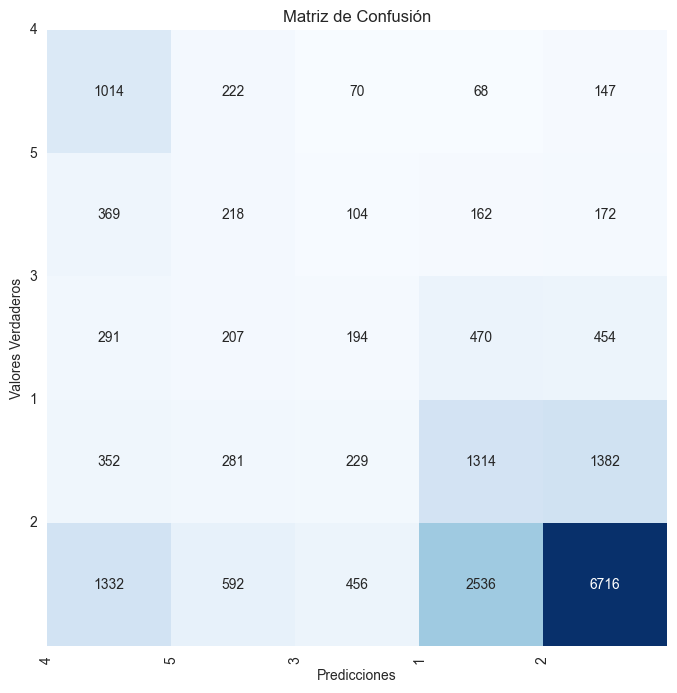

In [34]:
plot_confusion_matrix(confusion_rating, 8, 8, clases_rating.tolist())

### Clasificador MLP

In [35]:
predicciones_val_rating_MLP = mlp_rating.predict(X_rating_val)

In [36]:
accuracy_val_rating_MLP = accuracy_score(Y_rating_val, predicciones_val_rating_MLP)
print(f'Exactitud en los datos de entrenamiento: {accuracy_val_rating_MLP:.2f}')

Exactitud en los datos de entrenamiento: 0.65


In [37]:
confusion_rating_MLP = confusion_matrix(Y_rating_val, predicciones_val_rating_MLP)
print("Matriz de Confusión:")
print(confusion_rating_MLP)

Matriz de Confusión:
[[  970    47    46    24   434]
 [  297    61    86    57   524]
 [  143    59   137   169  1108]
 [   94    28    98   349  2989]
 [  172    42   118   326 10974]]


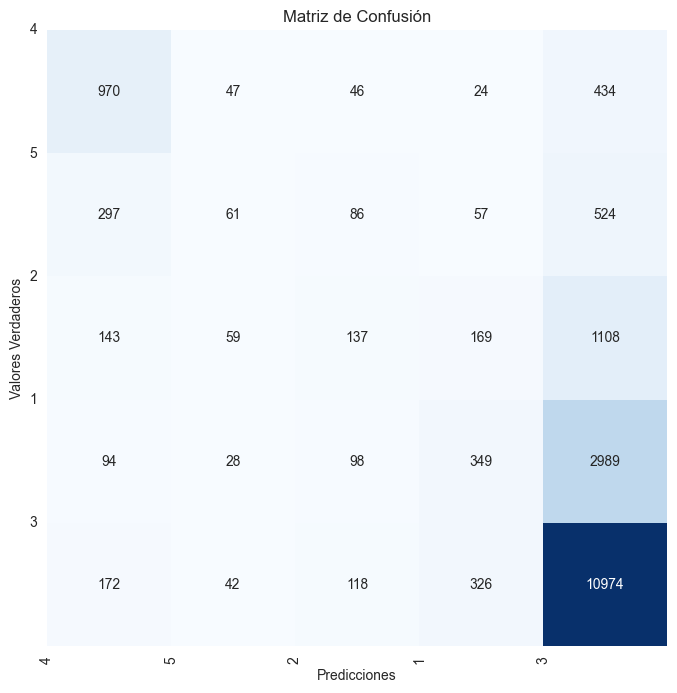

In [38]:
plot_confusion_matrix(confusion_rating_MLP, 8, 8, clases_rating_val.tolist())

### Validación del modelo para la hipótesis Precio

### Regresor MLP

In [39]:
predicciones_val_price = mlp_precio.predict(X_price_val)
mse_price_val = mean_squared_error(Y_price_val, predicciones_val_price)
mae_price_val = mean_absolute_error(Y_price_val, predicciones_val_price)
r2_price_val = r2_score(Y_price_val, predicciones_val_price)
rmse_price_val = np.sqrt(mse_price_val)
medae_prive_val = median_absolute_error(Y_price_val, predicciones_val_price)
print(f'Error cuadrático medio: {mse_price_val:.2f}')
print(f'Error absoluto medio: {mae_price_val:.2f}')
print(f'R-squared (variabilidad capturada): {r2_price_val:.2f}')
print(f'Raiz cuadrada del MSE: {rmse_price_val:.2f}')
print(f"Error Absoluto mediano: {medae_prive_val}") #Menos susceptible a valores extremos que el MAE

Error cuadrático medio: 7.27
Error absoluto medio: 0.78
R-squared (variabilidad capturada): 0.97
Raiz cuadrada del MSE: 2.70
Error Absoluto mediano: 0.18809154972800535


In [40]:
predicciones_val_price_df = pd.DataFrame({'Predicciones': predicciones_val_price})
predicciones_val_price_concat_df = pd.concat([df_price_val.reset_index(drop=True), predicciones_val_price_df], axis=1)
predicciones_val_price_concat_df.head(10)


,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,"publisher_""O'Reilly Media, Inc.""",publisher_Ags Pub,publisher_Amber House Books,publisher_Amereon Limited,...,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction,Price,Predicciones
0,-0.476078,0.657171,-0.421620,-0.888768,-1.014195,0.851032,0,0,0,0,...,1,0,0,0,0,0,0,0,48.27,47.207907
1,-1.023176,0.657171,-0.662528,-0.888768,-1.014195,0.267800,0,0,0,0,...,0,0,0,0,0,0,0,0,31.50,31.044711
2,1.260634,-0.140123,-0.669614,1.614321,1.221997,-1.093074,0,0,0,0,...,0,0,0,0,0,0,0,0,18.47,18.709687
3,-1.310775,0.657171,-0.586359,-0.888768,-1.014195,1.045443,0,0,0,0,...,0,0,0,0,0,0,0,0,34.00,33.419359
4,-0.996986,-2.532007,4.100721,-0.888768,-1.014195,0.267800,0,0,0,0,...,0,0,0,0,0,0,0,0,7.67,7.693712
5,0.708772,-0.140123,0.106252,0.426103,0.349554,0.851032,0,0,0,0,...,0,0,0,0,0,0,1,0,14.34,14.133565
6,0.403210,0.657171,1.851065,0.153242,0.160474,-0.769056,0,0,0,0,...,0,0,0,0,0,0,0,0,14.02,13.987277
7,-1.003473,-0.937418,0.108024,-0.888768,-1.014195,0.786229,0,0,0,0,...,0,0,0,0,0,0,0,0,28.20,27.313645
8,0.693116,-0.937418,0.471157,0.153242,0.349554,0.786229,0,0,0,0,...,0,0,1,0,0,0,0,0,108.00,108.001747
9,-0.984129,-1.734712,-0.015973,-0.231333,-0.426860,0.462211,0,0,0,0,...,0,0,0,0,0,0,0,0,7.04,7.460566


In [41]:
tamano_submuestra = 300  # Puedes ajustar esto al tamaño deseado

# Crea una submuestra aleatoria del DataFrame
submuestra_aleatoria = predicciones_val_price_concat_df.sample(n=tamano_submuestra, random_state=23)
submuestra_aleatoria

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,"publisher_""O'Reilly Media, Inc.""",publisher_Ags Pub,publisher_Amber House Books,publisher_Amereon Limited,...,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction,Price,Predicciones
9564,0.763047,-0.140123,-0.556245,0.637749,0.349554,-0.056217,0,0,0,0,...,0,0,0,0,0,0,0,0,25.43,24.334588
1354,0.394537,0.657171,-0.591673,0.426103,0.504043,0.202997,0,0,0,0,...,0,0,0,0,0,0,0,0,22.72,22.762969
14251,-0.588709,-2.532007,-0.616472,2.164266,2.688234,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,16.17,15.965657
13671,0.155244,0.657171,-0.465905,0.426103,0.349554,0.397407,0,0,0,0,...,0,0,0,0,0,0,0,0,13.18,13.040216
14865,0.596877,0.657171,0.269220,0.956886,1.280457,0.267800,0,0,0,0,...,0,0,0,0,0,0,0,0,18.97,19.124026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7087,-0.666296,0.657171,-0.510189,-0.888768,-0.426860,0.786229,0,0,0,0,...,0,0,0,0,0,0,0,0,10.87,10.782349
4470,0.071256,-1.734712,4.100721,-0.888768,-1.014195,0.267800,0,0,0,0,...,0,0,0,0,0,0,0,0,7.67,7.665498
8875,-0.488018,0.657171,-0.660757,0.637749,0.349554,-0.445039,0,0,0,0,...,0,0,0,0,0,0,0,0,14.93,14.906520
6264,-1.251599,0.657171,0.065510,-0.231333,-0.426860,-0.250628,0,0,0,0,...,0,0,0,0,0,0,0,0,10.20,10.308830


### Regresor Random Forest

In [42]:
predicciones_val_price_rf = rf_price.predict(X_price_val)
mse_price_rf_val = mean_squared_error(Y_price_val, predicciones_val_price_rf)
print(f'Error cuadrático medio: {mse_price_rf_val:.2f}')

Error cuadrático medio: 54.73


In [43]:
mae_price_val_rf = mean_absolute_error(Y_price_val, predicciones_val_price_rf)
r2_price_val_rf = r2_score(Y_price_val, predicciones_val_price_rf)
rmse_price_val_rf = np.sqrt(mse_price_rf_val)
medae_prive_val_rf = median_absolute_error(Y_price_val, predicciones_val_price_rf)
print(f'Error absoluto medio: {mae_price_val_rf:.2f}')
print(f'R-squared (variabilidad capturada): {r2_price_val_rf:.2f}')
print(f'Raiz cuadrada del MSE: {rmse_price_val_rf:.2f}')
print(f"Error Absoluto mediano: {medae_prive_val_rf}") #Menos susceptible a valores extremos que el MAE

Error absoluto medio: 5.06
R-squared (variabilidad capturada): 0.79
Raiz cuadrada del MSE: 7.40
Error Absoluto mediano: 4.28091185718805


In [44]:
predicciones_val_price_rf_df = pd.DataFrame({'Predicciones RF': predicciones_val_price_rf})
predicciones_val_price_concat_rf_df = pd.concat([df_price_val.reset_index(drop=True), predicciones_val_price_rf_df], axis=1)

# Crea una submuestra aleatoria del DataFrame
submuestra_aleatoria_rf = predicciones_val_price_concat_rf_df.sample(n=tamano_submuestra, random_state=23)
submuestra_aleatoria_rf

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,"publisher_""O'Reilly Media, Inc.""",publisher_Ags Pub,publisher_Amber House Books,publisher_Amereon Limited,...,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction,Price,Predicciones RF
9564,0.763047,-0.140123,-0.556245,0.637749,0.349554,-0.056217,0,0,0,0,...,0,0,0,0,0,0,0,0,25.43,14.670912
1354,0.394537,0.657171,-0.591673,0.426103,0.504043,0.202997,0,0,0,0,...,0,0,0,0,0,0,0,0,22.72,22.720000
14251,-0.588709,-2.532007,-0.616472,2.164266,2.688234,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,16.17,14.670912
13671,0.155244,0.657171,-0.465905,0.426103,0.349554,0.397407,0,0,0,0,...,0,0,0,0,0,0,0,0,13.18,14.670912
14865,0.596877,0.657171,0.269220,0.956886,1.280457,0.267800,0,0,0,0,...,0,0,0,0,0,0,0,0,18.97,14.670912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7087,-0.666296,0.657171,-0.510189,-0.888768,-0.426860,0.786229,0,0,0,0,...,0,0,0,0,0,0,0,0,10.87,14.670912
4470,0.071256,-1.734712,4.100721,-0.888768,-1.014195,0.267800,0,0,0,0,...,0,0,0,0,0,0,0,0,7.67,14.670912
8875,-0.488018,0.657171,-0.660757,0.637749,0.349554,-0.445039,0,0,0,0,...,0,0,0,0,0,0,0,0,14.93,15.884998
6264,-1.251599,0.657171,0.065510,-0.231333,-0.426860,-0.250628,0,0,0,0,...,0,0,0,0,0,0,0,0,10.20,14.670912
